In [21]:
#Importing of necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import nltk
import emoji
import demoji


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, make_scorer
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel, pipeline
from numpy import loadtxt, savetxt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, BatchNormalization, Bidirectional
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

#import bayes opt for hyperparameter tuning
from bayes_opt import BayesianOptimization

#We are going to use word vectorization to embed the words
import gensim
from gensim import downloader
import pickle

In [22]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\veena\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
#Reading in the dataset
df_tweets = pd.read_csv('tweets_data.csv')

# Baseline random model
Here, we implement a random classifier that assigns a observation a class based on the probabilities without taking into account any evidence. These probabilities are estimated from the frequencies of the respective classes in the dataset

In [24]:
df_tweets['isBot'].value_counts()


1    12786
0    12786
Name: isBot, dtype: int64

In [25]:
#There are 54420 thousand human tweets and 22278 bot tweets. Hence, the probability of a bot tweet based on frequency alone is
# approximately 29% and the probability of a human tweet is approximately 71%

def random_classifier(X, prob_bot = 0.5):
    #initialize a vector of 0s, these will be our predictions
    pred = np.zeros(len(X))
    for i in range(len(X)):
        probability = np.random.uniform()
        if probability <= prob_bot:
            pred[i] = 1
    return pred
        

In [26]:
y_pred = random_classifier(df_tweets)

print(classification_report(df_tweets['isBot'].apply(int), y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50     12786
           1       0.50      0.50      0.50     12786

    accuracy                           0.50     25572
   macro avg       0.50      0.50      0.50     25572
weighted avg       0.50      0.50      0.50     25572



From the above, we see that the f1 score for the human class is quite good, which is expected because we expect the classifier to assign 71% of the overall observations to the human class and the rest to the bot class.

However, the random classifier performs poorly for the minority class (bot tweets), with precision of 0.3 and recall of 0.29. 

Overall, we should expect any added complexity to our machine learning models to lead to an improvement of the scores above, and in particular to the bot class.

# Preprocessing of the textual data
Before we begin any modelling and analysis, it is a good idea to preprocess the text, because it is highly unstructured and not easily understood by machines.

We shall perform the following preprocessing steps:

1. Replacing URL's with "__url__"
2. Replacing emojis with the word representation of them
3. Replacing all user mentions with __user_mention__
4. Removing all hashtags

We also avoid performing stemming and lemmatization because we may lose key words present in the tweets

In [27]:
#detect html patterns
CLEANR = re.compile('<.*?>') 
#replace the new line characters
def process_text(text):
    txt_lst = text.split()
    
    #A helper function to process emojis
    #Emojis are left in in order to 
    def process_emoji(emo):
        try:
            decoded = emoji.demojize(emo)
            decoded = decoded.replace(":", "")
            return decoded
        except UnicodeDecodeError:
            #if unable to decode emoji, just keep a place holder for it
            return "__emoji__"
    
    #store all emojis as the decoded form
    txt_lst = [process_emoji(x) if emoji.is_emoji(x) else x for x in txt_lst]
    
    #process all tagged accounts
    def process_tagged_accounts(account):
        #replace all tagged accounts with __user_mention__
        if account.startswith("@") and len(account) > 1:
            return "__user_mention__"
        return account
    
    #replace hashtags with place holders
    def process_hashtags(text):
        if text.startswith("#"):
            return "__hashtag__"
        return text
    
    
    #apply the functions above
    txt_lst = [process_tagged_accounts(x) for x in txt_lst]
    txt_lst = [process_hashtags(x) for x in txt_lst]
    
    #next, we process the urls
    def process_urls_html(text):
        pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
        text = re.sub(pattern, "", text)
        text = re.sub(CLEANR, "", text)
        return text
    
    text = " ".join(txt_lst)
    
    final_text = process_urls_html(text)
    return final_text
        
    

        
    
    
            
    
        
    
    

In [28]:
#Apply the function defined above and create a new column for stored text
cleaned_text = df_tweets['text'].apply(process_text)

In [29]:
df_tweets['cleaned_text'] = cleaned_text

In [30]:
df_tweets.head()

,Unnamed: 0,text,isBot,cleaned_text
0,0,YEA now that note GOOD,1,YEA now that note GOOD
1,1,Listen to This Charming Man by The Smiths htt...,0,Listen to This Charming Man by The Smiths
2,2,wish i can i would be seeing other hoes on the...,1,wish i can i would be seeing other hoes on the...
3,3,The decade in the significantly easier schedul...,1,The decade in the significantly easier schedul...
4,4,"""Theim class=\""alignnone size-full wp-image-60...",1,"""Theim class=\""alignnone size-full wp-image-60..."


# Exploratory data analysis
Here, we perform some simple eda on the data, namely wordclouds for the different classes and K means clustering. We also perform cosine simililarity test to see how different BOW vectors are within and across the classes

In [31]:
#Creating bot tweet and human tweet dataframes
bot_tweets = df_tweets[df_tweets.isBot == 1][['cleaned_text']].copy()
human_tweets = df_tweets[df_tweets.isBot == 0][['cleaned_text']].copy()

In [32]:
stop = list(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()
#removing these words to get a better idea of the differences in vocab
contextual_stop = ['day','new','one', 'time','need', "__user_mention__", "__hashtag__"]
stop = stop + contextual_stop

#Create a function that plots a word cloud using the tokens
def plot_word_cloud(df):
    df['tokenized'] = df['cleaned_text'].apply(word_tokenize)
    
    df['processed_data'] = df.tokenized.apply(lambda x: [word.casefold() for word in x if word.casefold() not in stop
                                                                    and word not in contextual_stop])
    df['processed_data'] = df.processed_data.apply(lambda x:[lemmatizer.lemmatize(word) for word in x])
    df['sentence'] = df['processed_data'].apply(lambda x:' '.join(x))
    
    big_sentence = ''

    for sentence in df['sentence']:
        big_sentence += sentence

    wordcloud = WordCloud(background_color='white').generate(text = big_sentence)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation = 'bilinear')

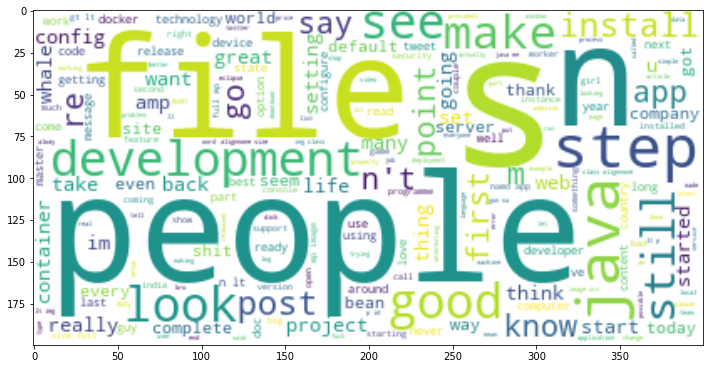

In [33]:
#Word cloud for bots
plot_word_cloud(bot_tweets)

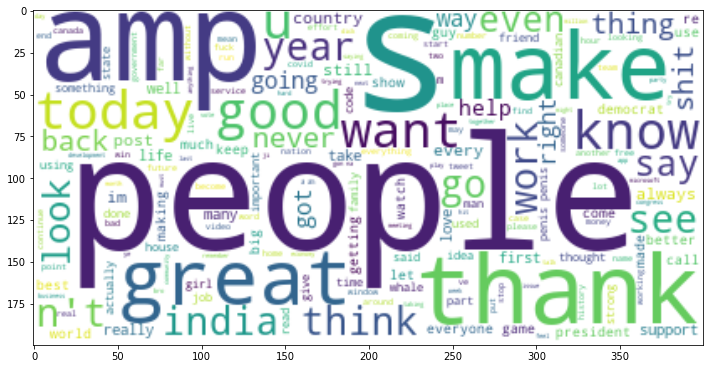

In [34]:
#Word cloud for humans
plot_word_cloud(human_tweets)

# Bag of Words model
We shall start off with the simplest model for test classfication, ie a bag of words model, which simply stores the count of each word in the vocabulary for each tweet, which results in a rather sparse representation of each tweet

In [49]:
#tokenize the words in the tweet

df_tweets['tokenized'] = df_tweets['cleaned_text'].apply(word_tokenize)

In [50]:
#get a list of all stopwords
stop = list(stopwords.words('english'))




In [51]:
#Removed stop words
df_tweets['processed_data'] = df_tweets.tokenized.apply(lambda x: [word.casefold() for word in x if word.casefold() not in stop
                                                                    and word not in contextual_stop])
#lemmatize the words
df_tweets['processed_data'] = df_tweets.processed_data.apply(lambda x:[lemmatizer.lemmatize(word) for word in x])

df_tweets['sentence'] = df_tweets['processed_data'].apply(lambda x : " ".join(x))
#Change the sentence to lower case
df_tweets['sentence'] = df_tweets['sentence'].str.lower()

In [52]:
#Now we create the BOW vectors
#Next, we initialize a count vectorizer and transform the text into Bag of Words vectors, if some word appears in more than half, we ignore that word
vectorizer = CountVectorizer(max_df = 0.5, min_df = 10)
#Create an array that contains the BOW representation of each tweet
bow_array  = vectorizer.fit_transform(df_tweets['sentence'])
#Converting the result into a pandas dataframe
bow = pd.DataFrame(bow_array.toarray(),columns = vectorizer.get_feature_names_out())

Before fitting any machine learning models on the BOW vectors, let us see if there are any meaningful clusters in the BOW features. If the BOW features are significantly different between humans and bots, then we should expect to see clusters in which the proportion of bot tweets vs human tweets is significantly different from the normal dataset.

In [53]:
kmeans_df = df_tweets.copy()

#we shall use K = 2 because that is the number of natural clusters in the dataset (bot vs human tweets)
kmeans_bow = KMeans(n_clusters = 2)

kmeans_bow.fit(bow)


KMeans(n_clusters=2)

In [54]:
#Extracting the labels and seeing whether there is any meaningful separation in the dataset

kmeans_df['cluster_labels'] = kmeans_bow.labels_

cluster_0 = kmeans_df[kmeans_df.cluster_labels == 0]

#seeing if there proportion of labels is any different as compared to the full dataset
cluster_0['isBot'].value_counts()

#this cluster is quite interesting because most of the tweets are human tweets

0    1018
1     293
Name: isBot, dtype: int64

In [55]:
#Let us further investigate this particular cluster
cluster_0.head()


,Unnamed: 0,text,isBot,cleaned_text,tokenized,processed_data,sentence,cluster_labels
15,15,"@TheOccStevie @WizardMarnok @seb_ly ""you make ...",0,__user_mention__ __user_mention__ __user_menti...,"[__user_mention__, __user_mention__, __user_me...","[__user_mention__, __user_mention__, __user_me...",__user_mention__ __user_mention__ __user_menti...,0
16,16,@JamieMcKinnon7 @PaigeHHarvey @frontierdev @Da...,0,__user_mention__ __user_mention__ __user_menti...,"[__user_mention__, __user_mention__, __user_me...","[__user_mention__, __user_mention__, __user_me...",__user_mention__ __user_mention__ __user_menti...,0
56,56,"“President Trump, with smart policies, has don...",0,"“President Trump, with smart policies, has don...","[“, President, Trump, ,, with, smart, policies...","[“, president, trump, ,, smart, policy, ,, don...","“ president trump , smart policy , done help b...",0
102,102,@jpbrammer @h_jonesphoto I used to type “cigar...,0,__user_mention__ __user_mention__ I used to ty...,"[__user_mention__, __user_mention__, I, used, ...","[__user_mention__, __user_mention__, used, typ...",__user_mention__ __user_mention__ used type “ ...,0
117,117,Primarily @ImpossibleFoods and @justforall,0,Primarily __user_mention__ and __user_mention__,"[Primarily, __user_mention__, and, __user_ment...","[primarily, __user_mention__, __user_mention__]",primarily __user_mention__ __user_mention__,0


In [56]:
cluster_1 = kmeans_df[kmeans_df.cluster_labels == 1]
cluster_1['isBot'].value_counts()

1    12493
0    11768
Name: isBot, dtype: int64

In [57]:
#Next, treat the BOW vectors as features and split the data into training and testing sets
X = bow
y = df_tweets['isBot']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [58]:
#Instantiate and train a logistic regression model
model_log_reg_bow = LogisticRegression(max_iter = 100000)

model_log_reg_bow.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [59]:
y_pred = model_log_reg_bow.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70      2606
           1       0.69      0.71      0.70      2509

    accuracy                           0.70      5115
   macro avg       0.70      0.70      0.70      5115
weighted avg       0.70      0.70      0.70      5115



In [60]:
#Let us calculate the score under the ROC curve for the logistic regression model with BOW
probabilities = model_log_reg_bow.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities))

0.7914290595299746


In [61]:
#Try fitting a more complex function like the random forest for this problem
model_rf_bow = RandomForestClassifier()
model_rf_bow.fit(X_train, y_train)

RandomForestClassifier()

In [62]:
#print the classification report for random forest
y_pred = model_rf_bow.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      2606
           1       0.70      0.73      0.72      2509

    accuracy                           0.71      5115
   macro avg       0.71      0.71      0.71      5115
weighted avg       0.71      0.71      0.71      5115



In [63]:
#Calculating the ROC score for the random forest
probabilities = model_rf_bow.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities))

0.7955899819743322


In [64]:
#Next, instead of bag of words, we can consider TfIdf vectors instead, which could potentially identify rare but useful words
#that serve as useful features for classification
#Repeat the above process, but this time instead of using bag of words vectors, we use tfidf vectors
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 10)
#Create an array that contains the BOW representation of each tweet
tfidf_bow_array  = tfidf_vectorizer.fit_transform(df_tweets['sentence'])
#Converting the result into a pandas dataframe
tfidf_bow = pd.DataFrame(tfidf_bow_array.toarray(),columns = tfidf_vectorizer.get_feature_names_out())


In [65]:
#Same process as above
X = tfidf_bow 
y = df_tweets['isBot']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [66]:
model_log_reg_tfidf = LogisticRegression(max_iter = 100000)

model_log_reg_tfidf.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [67]:
y_pred = model_log_reg_tfidf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      2547
           1       0.70      0.71      0.71      2568

    accuracy                           0.70      5115
   macro avg       0.70      0.70      0.70      5115
weighted avg       0.70      0.70      0.70      5115



In [68]:
probabilities = model_log_reg_tfidf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities))

0.7942558406628285


In [69]:
model_rf_tfidf = RandomForestClassifier()
model_rf_tfidf.fit(X_train, y_train)

RandomForestClassifier()

In [70]:
y_pred = model_rf_tfidf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2547
           1       0.73      0.74      0.74      2568

    accuracy                           0.73      5115
   macro avg       0.73      0.73      0.73      5115
weighted avg       0.73      0.73      0.73      5115



In [83]:
probabilities = model_rf_tfidf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities))

0.8159552188923851


# LSTM

The bag of words models gave us relatively better performance as compared to the baseline but there is still potential for improvement.

Bag of words models (and TFIDF models) do not capture the meaning and the sequential information that is inherently present in textual data. Hence, next, we shall consider a model that does consider the sequence and that is the LSTM. First, before passing our data into the LSTM, we should consider a word embedding which embeds each token into a vector which is then passed in as the features for the LSTM.

First, we shall consider training our own word2vec model to get the word embeddings.

In [84]:
#First, we include a short form dictionary, which replaces all comomon short forms to the respective long forms, then we process
#the tweets to replace such short forms to long forms, this is because word2vec models cannot deal well with punctuation.
#In addition, pre trained models (gLove in our case) do not contain embeddings for short form of words
short_form_dict = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",}

def change_short_form(text):
    for key, value in short_form_dict.items():
        text = text.replace(key, value)
    return text

In [85]:
#before constructing the word embedding, we should split the data into training and testing sets in order to avoid data leakage
#create the X and y classes
y = df_tweets.isBot
#create the copy for X, specific to the LSTM task
X = df_tweets[['cleaned_text']].copy()
X['cleaned_text'] = X['cleaned_text'].apply(change_short_form)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [86]:
X_train_sentence = [d.split() for d in X_train['cleaned_text'].tolist()]

In [87]:
#create the word to vector
#try a 100 dimensional vector first
dim = 100
#Fit a Word2Vec model on our dataset
w2v = gensim.models.Word2Vec(sentences = X_train_sentence, vector_size = dim, window = 10, min_count = 1)

In [88]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_sentence)

In [89]:
#tokenize the words (this is for padding later)
X_train_tokens = tokenizer.texts_to_sequences(X_train_sentence)

In [90]:
#Since twitter only allows 280 characters, we shall keep the max length to
#the greater of 100 or whatever maximum length is found in the dataset
max_length = max(100, max(len(x) for x in X_train_tokens))


In [91]:
#Next, we can pad the sequences
X_train_tokens = pad_sequences(X_train_tokens, maxlen = max_length)

In [92]:
vocabulary_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [93]:
#create the embedding matrix according to our word embeddings, this matrix is to store all the word embeddings according to
#our training above (each word gets its own vector)
embedding_mat = np.zeros((vocabulary_size, dim))
num_words = 0
#insert the word embeddings into our initialised object
for word, token in tokenizer.word_index.items():

    #get the corresponding vector to the word and the token
    #if the word is present in the dictionary, then we append the corresponding matrix else we continue
    if word in w2v.wv:
        vector = w2v.wv[word]
        embedding_mat[token] = vector
        num_words +=1



In [94]:
#Finally, we can create an LSTM architecture to classify the examples
model = Sequential()
#create the embedding layer for the conversion of inputs to embedded vectors
model.add(Embedding(vocabulary_size, output_dim = dim, weights = [embedding_mat], input_length = max_length, trainable = False))
#All these LSTMS run for a 100 "timesteps" as determined by the max length parameter the units is the determine the outputsize
model.add(LSTM(units = 128, recurrent_dropout=0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [95]:
model.fit(X_train_tokens, y_train,  epochs = 15)

Epoch 1/15
640/640 [==============================] - 76s 110ms/step - loss: 0.5610 - acc: 0.6870
Epoch 2/15
640/640 [==============================] - 68s 106ms/step - loss: 0.5122 - acc: 0.7196
Epoch 3/15
640/640 [==============================] - 68s 107ms/step - loss: 0.4941 - acc: 0.7313
Epoch 4/15
640/640 [==============================] - 68s 107ms/step - loss: 0.4818 - acc: 0.7421
Epoch 5/15
640/640 [==============================] - 69s 107ms/step - loss: 0.4718 - acc: 0.7458
Epoch 6/15
640/640 [==============================] - 68s 107ms/step - loss: 0.4653 - acc: 0.7512
Epoch 7/15
640/640 [==============================] - 68s 107ms/step - loss: 0.4597 - acc: 0.7542
Epoch 8/15
640/640 [==============================] - 68s 107ms/step - loss: 0.4513 - acc: 0.7608
Epoch 9/15
640/640 [==============================] - 68s 107ms/step - loss: 0.4481 - acc: 0.7614
Epoch 10/15
640/640 [==============================] - 68s 107ms/step - loss: 0.4427 - acc: 0.7597
Epoch 11/15
640/640

In [96]:
#applying the preprocessing steps on the test set and seeing the performance
X_test_sentence = [d.split() for d in X_test['cleaned_text'].tolist()]
X_test_tokens = tokenizer.texts_to_sequences(X_test_sentence)

In [97]:
X_test_tokens = pad_sequences(X_test_tokens, maxlen = max_length)

In [98]:
y_pred = np.where(model.predict(X_test_tokens) > 0.5, 1,0)

160/160 [==============================] - 7s 28ms/step


In [99]:
y_pred = y_pred.reshape((y_pred.shape[0],))


In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      2571
           1       0.70      0.79      0.74      2544

    accuracy                           0.73      5115
   macro avg       0.73      0.73      0.73      5115
weighted avg       0.73      0.73      0.73      5115



In [101]:
#find the roc curve score for the LSTM with self trained word embeddings
probabilities = model.predict(X_test_tokens)
probabilities = probabilities.reshape((probabilities.shape[0],))
print(roc_auc_score(y_test, probabilities))

160/160 [==============================] - 5s 30ms/step
0.8195867856033308


We shall also try an LSTM model with a pretrained GLOVE model. Here, instead of training our own embeddings, we use pretrained embeddings trained on a huge corpus to see if results are better. The glove model used here is pretrained on billions of tweets

In [102]:
glove_twitter = downloader.load('glove-twitter-100')

In [103]:
#Perfrom the same steps as above but this time use the pretrained model
#create the embedding matrix according to our word embeddings, this matrix is to store all the word embeddings according to
#our training above (each word gets its own vector)
dim = 100
embedding_mat_glove = np.zeros((vocabulary_size, dim))
num_words = 0
#insert the word embeddings into our initialised object
for word, token in tokenizer.word_index.items():
    
    #first, we remove any punctuation from the words and store a modified version of the word
    word_modified = ''.join(c for c in word if c.isalnum())
    #get the corresponding vector to the word and the token
    #if the word is present in the dictionary, then we append the corresponding matrix else we continue
    if word_modified in glove_twitter:
        vector = glove_twitter[word_modified]
        embedding_mat_glove[token] = vector
        num_words +=1
    #if the word does not exist in the pretrained glove, then we obtain from our trained model, ie the w2v model
    elif word in w2v.wv:
        vector = w2v.wv[word]
        num_words += 1
  

In [104]:
#Finally, we can create an LSTM architecture to classify the examples
model_glove_pretrained = Sequential()
#create the embedding layer for the conversion of inputs to embedded vectors
model_glove_pretrained.add(Embedding(vocabulary_size, output_dim = dim, weights = [embedding_mat_glove], input_length = max_length, trainable = False))
#All these LSTMS run for a 100 "timesteps" as determined by the max length parameter the units is the determine the outputsize
model_glove_pretrained.add(LSTM(units = 128, recurrent_dropout=0.3))
model_glove_pretrained.add(Dense(1, activation = 'sigmoid'))
model_glove_pretrained.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [113]:
model_glove_pretrained.fit(X_train_tokens, y_train,  epochs = 8)

Epoch 1/8
640/640 [==============================] - 98s 154ms/step - loss: 0.1418 - acc: 0.9474
Epoch 2/8
640/640 [==============================] - 98s 153ms/step - loss: 0.1258 - acc: 0.9520
Epoch 3/8
640/640 [==============================] - 101s 158ms/step - loss: 0.1153 - acc: 0.9596
Epoch 4/8
640/640 [==============================] - 101s 158ms/step - loss: 0.0979 - acc: 0.9660
Epoch 5/8
640/640 [==============================] - 99s 154ms/step - loss: 0.0954 - acc: 0.9662
Epoch 6/8
640/640 [==============================] - 101s 158ms/step - loss: 0.0869 - acc: 0.9695
Epoch 7/8
640/640 [==============================] - 101s 159ms/step - loss: 0.0775 - acc: 0.9743
Epoch 8/8
640/640 [==============================] - 100s 156ms/step - loss: 0.0703 - acc: 0.9777


In [114]:
y_pred = np.where(model_glove_pretrained.predict(X_test_tokens) > 0.5, 1,0)

160/160 [==============================] - 7s 43ms/step


In [115]:
y_pred = y_pred.reshape((y_pred.shape[0],))


In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.70      2571
           1       0.70      0.71      0.70      2544

    accuracy                           0.70      5115
   macro avg       0.70      0.70      0.70      5115
weighted avg       0.70      0.70      0.70      5115



In [117]:
y_pred_training = np.where(model_glove_pretrained.predict(X_train_tokens) > 0.5, 1,0)

640/640 [==============================] - 28s 43ms/step


In [118]:
y_pred_training = y_pred_training.reshape((y_pred_training.shape[0],))

In [119]:
#Appears to be some kind of overfitting on the train
print(classification_report(y_train, y_pred_training))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     10215
           1       0.79      0.80      0.79     10242

    accuracy                           0.79     20457
   macro avg       0.79      0.79      0.79     20457
weighted avg       0.79      0.79      0.79     20457



In [120]:
#find the roc curve score for the LSTM with pretrained glove embeddings
probabilities = model_glove_pretrained.predict(X_test_tokens)
probabilities = probabilities.reshape((probabilities.shape[0],))
print(roc_auc_score(y_test, probabilities))

160/160 [==============================] - 7s 45ms/step
0.7947502409556031


# BERT
While previously the word embeddings from Glove are not fully context dependent, let us consider an embedding that considers both context and both directions, ie the BERT word embedding

Here, first, we generate the BERT feature vector for each tweet and then we train models on those feature representations 

In [2]:
#initialising a pretrained bert model
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", padding = True)
model = BertModel.from_pretrained("bert-base-cased")
nlp = pipeline("feature-extraction", tokenizer=tokenizer, model=model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
#store all the tweets after they have been encoded by BERT

feature_vectors = []

for index, row in df_tweets.iterrows():
    #extracting the ith tweet and restricting the characters to 512, which is fine because twitter's limit is 280
    text = row['cleaned_text'][:512]
    #encoding all the individual words present in the tweet
    vec = np.array(nlp(text))
    #getting the mean representation of the words present in the tweet
    vec = vec.reshape((vec.shape[1], vec.shape[2])).mean(axis = 0)
    feature_vectors.append(vec)





In [16]:
#finally, transform the generated vector list to a numpy array
feature_vectors = np.array(feature_vectors)

In [17]:
#splitting the generated features into training and testing features
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, df_tweets['isBot'], test_size = 0.2)

In [15]:
#Training a logistic regression on the pretrained BERT features
model_bert_log_reg = LogisticRegression(max_iter = 100000) #setting an arbitrarily high number in order to ensure convergence
model_bert_log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [16]:
y_pred = model_bert_log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2513
           1       0.81      0.79      0.80      2602

    accuracy                           0.80      5115
   macro avg       0.80      0.80      0.80      5115
weighted avg       0.80      0.80      0.80      5115



In [17]:
#Training an SVC on the pretrained BERT features
model_bert_svc = SVC()
model_bert_svc.fit(X_train, y_train)

SVC()

In [18]:
#seeing the svc performance on the test set
y_pred = model_bert_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2513
           1       0.83      0.81      0.82      2602

    accuracy                           0.82      5115
   macro avg       0.82      0.82      0.82      5115
weighted avg       0.82      0.82      0.82      5115



In [132]:
#Try xgboost model
model_xgb_bert = XGBClassifier()
model_xgb_bert.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [133]:
y_pred = model_xgb_bert.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2567
           1       0.80      0.80      0.80      2548

    accuracy                           0.80      5115
   macro avg       0.80      0.80      0.80      5115
weighted avg       0.80      0.80      0.80      5115



In [136]:
#ROC score for xgboost
probabilities = model_xgb_bert.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities))

0.9028785992236937


# Hyperparameter tuning and final model selection
We shall perform hyperparameter tuning for the models that use BERT features as the features. The method we will use to perform this tuning is Bayesian Optimisation, which is more efficient in finding the best hyperparameters as compared to Random Search and Grid Search as those 2 methods treat each trial of hyperparameters independently while Bayesian optimization is an informed search in the hyperparameter space in order to optimize the objective function.

However, in the context of Random Forest, since most of the features are discrete, we used random search instead.

Then, the tuned models will be tested on an independent test set and the best performing model will be selected based on this test set.

(Note, the results are likely to be different each time the notebook is run)

In [11]:
#Recreating the train test split:
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, df_tweets['isBot'], test_size = 0.2)

In [29]:
#running bayesian optimization for Logistic regression

#First, we decide on the parameter space for each attribute

param_space = {'penalty': (1,2), 'C':(10e-4, 10)}

#next, define a function that generates what we want to optimize
def logistic_regression_to_optimize(penalty, C):
    penalty = int(penalty)
    norm = ''
    if penalty == 1:
        norm = 'l2'
    elif penalty == 2:
        norm = 'none'

    
        
    log_reg = LogisticRegression(penalty=norm, C = C, max_iter = 100000)
    
    #we use cv on the training set because we do not want to use the test set to tune parameters
    
    cross_val = cross_val_score(log_reg, X_train, y_train, scoring = make_scorer(accuracy_score))
    
    
    
    return (np.mean(cross_val))
    

In [30]:
optimal_log_reg = BayesianOptimization(logistic_regression_to_optimize, param_space)

optimal_log_reg.maximize(n_iter = 20, init_points = 25, acq = 'ei')

|   iter    |  target   |     C     |  penalty  |
-------------------------------------------------
| 1         | 0.7935    | 9.416     | 1.458     |
| 2         | 0.7937    | 6.049     | 1.829     |
| 3         | 0.7938    | 5.709     | 1.709     |
| 4         | 0.7957    | 1.547     | 1.374     |
| 5         | 0.7956    | 1.794     | 1.163     |
| 6         | 0.7963    | 1.222     | 1.241     |
| 7         | 0.7935    | 9.839     | 1.488     |
| 8         | 0.7957    | 1.554     | 1.703     |
| 9         | 0.7911    | 0.06911   | 1.691     |
| 10        | 0.7938    | 4.485     | 1.065     |
| 11        | 0.7938    | 5.604     | 1.26      |
| 12        | 0.7938    | 4.919     | 1.01      |
| 13        | 0.7953    | 2.118     | 1.501     |
| 14        | 0.7941    | 3.511     | 1.938     |
| 15        | 0.7936    | 6.733     | 1.777     |
| 16        | 0.7939    | 6.993     | 1.751     |
| 17        | 0.7936    | 6.494     | 1.202     |
| 18        | 0.7939    | 4.579     | 1.402     |


C:\Users\veena\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\veena\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\veena\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\veena\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\veena\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


| 40        | 0.7929    | 1.228     | 2.0       |
| 41        | 0.7951    | 2.475     | 1.986     |
| 42        | 0.7962    | 1.186     | 1.356     |
| 43        | 0.796     | 1.017     | 1.12      |
| 44        | 0.7962    | 0.9399    | 1.491     |
| 45        | 0.7936    | 8.132     | 1.025     |


In [33]:
#Running bayesian optimization for xgboost
param_space = {'max_depth' : (1, 30), 
                                   'eta' : (0, 0.2), 
                                   'gamma' : (0, 1),
                                   'subsample' : (0, 1),
                                   'colsample_bytree' : (0, 1),
                                   'alpha' : (0, 1)}
def xgboost_to_optimize(max_depth, eta, gamma, subsample, colsample_bytree, alpha):
    max_depth = int(max_depth)
    
    xgb_classifier = XGBClassifier(max_depth = max_depth, 
                                       eta = eta, 
                                       gamma = gamma,
                                       subsample = subsample,
                                       colsample_bytree = colsample_bytree,
                                       alpha = alpha,
                                       objective = "binary:logistic",
                                       eval_metric = "logloss")
    
    #again, use cross validation on the training data to evaluate the parameters instead of the test set to avoid
    #overfitting the test set
    cross_val = cross_val_score(xgb_classifier, X_train, y_train, scoring = make_scorer(accuracy_score))
    
    return (np.mean(cross_val))

In [35]:
optimal_xgb = BayesianOptimization(xgboost_to_optimize, param_space)

optimal_xgb.maximize(n_iter = 20, init_points = 25, acq = 'ei')

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.796     | 0.2847    | 0.3397    | 0.1439    | 0.8268    | 19.04     | 0.3687    |
| 2         | 0.8012    | 0.5233    | 0.808     | 0.1128    | 0.1542    | 9.73      | 0.6042    |
| 3         | 0.785     | 0.4731    | 0.07003   | 0.1772    | 0.124     | 22.57     | 0.4101    |
| 4         | 0.7975    | 0.8066    | 0.1697    | 0.1871    | 0.91      | 18.2      | 0.5619    |
| 5         | 0.7271    | 0.2313    | 0.04604   | 0.05305   | 0.3116    | 1.622     | 0.9899    |
| 6         | 0.7478    | 0.3967    | 0.01326   | 0.01873   | 0.1696    | 8.594     | 0.292     |
| 7         | 0.7252    | 0.6282    | 0.005511  | 0.1885    | 0.1974    | 10.14     | 0.1802    |
| 8         | 0.7843    | 0.5874    | 0.5576    | 0.001156  | 0.8794    | 29.23     | 0.8131    |
| 9         | 0.7321

In [44]:
print(optimal_xgb.max['params'])

{'alpha': 0.6561436763727414, 'colsample_bytree': 0.8044712005134521, 'eta': 0.16109546170059863, 'gamma': 0.37272014011820453, 'max_depth': 11.917599459123359, 'subsample': 0.8833958626743582}


In [40]:
#Parameter optimization for random forest. For random forest, we used RandomSearch instead of Bayesian optimization because
#most of the parameters were discrete

param_space = {'n_estimators':[10, 50, 200, 600, 800, 1200],
              'max_features':['auto', 'sqrt', 'log2'],
               'max_depth':[None, 10, 40, 80, 120],
               'min_samples_split':[2, 10, 40, 100],
               'bootstrap':[True, False]              
              }

rf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(estimator = rf,
                                   param_distributions = param_space,
                                   scoring = make_scorer(accuracy_score),
                                   n_jobs = -1,
                                   cv = 5,
                                   verbose = 10,
                                   n_iter = 20
                                   )

random_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 40, 80, 120],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [2, 10, 40, 100],
                                        'n_estimators': [10, 50, 200, 600, 800,
                                                         1200]},
                   scoring=make_scorer(accuracy_score), verbose=10)

In [42]:
print(random_search_rf.best_score_)

print(random_search_rf.best_params_)


0.7868701245109726
{'n_estimators': 600, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': False}


In [18]:

#Finally, we tune the support vector classifier
param_grid = {'C': (0.1,100), 'gamma': (0.001,1),'kernel': (1,3)}

def svc_to_optimize(C, gamma, kernel):
    kernel = int(kernel)
    to_use = ''
    if kernel == 1:
        to_use = 'rbf'
    elif kernel == 2:
        to_use = 'sigmoid'
    else:
        to_use = 'poly'
        
    
    
    svc = SVC(C = C, gamma = gamma, kernel = to_use)
    
    #again, use cross validation on the training data to evaluate the parameters instead of the test set to avoid
    #overfitting the test set
    cross_val = cross_val_score(svc, X_train, y_train, scoring = make_scorer(accuracy_score))
    
    return (np.mean(cross_val))

In [20]:
optimal_svc = BayesianOptimization(svc_to_optimize, param_grid)

optimal_svc.maximize(n_iter = 3, init_points = 3, acq = 'ei')

|   iter    |  target   |     C     |   gamma   |  kernel   |
-------------------------------------------------------------
| 1         | 0.5004    | 69.88     | 0.8248    | 2.453     |
| 2         | 0.5004    | 61.45     | 0.9193    | 2.937     |
| 3         | 0.5004    | 8.519     | 0.5346    | 2.161     |
| 4         | 0.6291    | 99.99     | 0.5853    | 1.142     |
| 5         | 0.6386    | 99.5      | 0.6185    | 1.221     |
| 6         | 0.5611    | 96.91     | 0.7946    | 1.642     |


In [16]:
print(optimal_svc.max['params'])

{'C': 71.59957717184287, 'gamma': 0.0535642167483735, 'kernel': 1.0876455691743228}


In [17]:
#We then fit each of the models with their best parameters in the training data and then evaluate the model on the held out 
#test set

In [18]:
#Fitting a tuned Logistic regression model

log_reg_tuned = LogisticRegression(C = 1.287, max_iter = 100000)
log_reg_tuned.fit(X_train, y_train)

y_pred = log_reg_tuned.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80      2533
           1       0.81      0.77      0.79      2582

    accuracy                           0.79      5115
   macro avg       0.79      0.79      0.79      5115
weighted avg       0.79      0.79      0.79      5115



In [21]:
probabilities_log_reg_tuned = log_reg_tuned.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities_log_reg_tuned))

0.8819710724708059


In [22]:
#fitting a tuned xgboost model
xgboost_tuned = XGBClassifier(alpha= 0.6561436763727414, colsample_bytree= 0.8044712005134521, 
                              eta = 0.16109546170059863, 
                              gamma= 0.37272014011820453, 
                              max_depth = 11, 
                              subsample = 0.8833958626743582)
xgboost_tuned.fit(X_train, y_train)

y_pred = xgboost_tuned.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2533
           1       0.81      0.81      0.81      2582

    accuracy                           0.81      5115
   macro avg       0.81      0.81      0.81      5115
weighted avg       0.81      0.81      0.81      5115



In [23]:
probabilities_xgboost_tuned = xgboost_tuned.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities_xgboost_tuned))

0.9038844495112234


In [24]:
#Fitting a tuned random forest model
rf_tuned = RandomForestClassifier(n_estimators= 600, 
                                  min_samples_split = 10, 
                                  max_features = 'sqrt', 
                                  max_depth = 120, 
                                  bootstrap = False)
rf_tuned.fit(X_train, y_train)

y_pred = rf_tuned.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2533
           1       0.80      0.80      0.80      2582

    accuracy                           0.80      5115
   macro avg       0.80      0.80      0.80      5115
weighted avg       0.80      0.80      0.80      5115



In [25]:
probabilities_rf_tuned = rf_tuned.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities_rf_tuned))

0.8923502562457514


In [28]:
#Fitting a tuned svm model and enabling probability = True to allow for probabilistic predictions during deployment
svm_tuned = SVC(C = 71.6, 
               gamma = 0.05356,
               kernel = 'rbf', probability=True)
svm_tuned.fit(X_train, y_train)

y_pred = svm_tuned.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2533
           1       0.84      0.84      0.84      2582

    accuracy                           0.84      5115
   macro avg       0.84      0.84      0.84      5115
weighted avg       0.84      0.84      0.84      5115



In [29]:
probabilities_svm_tuned = svm_tuned.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, probabilities_svm_tuned))

0.9286001083146309


# Final model training and saving

Here, we train the final model to be deployed into the flask server. From the above metrics from the various models, we can see that SVC with parameters of C = 71.6, gamma = 0.05356 and an radial basis function kernel performs the best.

In [30]:
#training the final model on all datapoints

model_bert = SVC(C = 71.6, 
               gamma = 0.05356,
               kernel = 'rbf', probability=True)
model_bert.fit(feature_vectors, df_tweets['isBot'])

SVC(C=71.6, gamma=0.05356, probability=True)

In [31]:
#saving the final model for deployment
pickle.dump(model_bert, open("../flask/Bert_model.sav", 'wb'))